> Code to accompany **Chapter 5: The Principles of Adversarial Input**

# Saliency Maps for ResNet - Using LIME and keras-vis

This Jupyter notebook illustrates the use of saliency maps to establish the most important aspects of an image to the predictions made by a DNN.

In the book, this was demonstrated with the [Keras Visualization Toolkit](https://github.com/raghakot/keras-vis). This uses model gradients to establish the most salient features of the image. It assumes, however, that the gradients are *linear* and so is an estimation.

An alternative approach to creating saliency maps is that taken by [LIME - Local Interpretable Model-Agnostic Explanations](https://lime-ml.readthedocs.io/en/latest/index.html). LIME feeds many variations (perturbations) of the input into the classifier (or any block-box algorithm) and sees the affect that each change has on the output. From this, LIME can establish which aspects of the image (or other input) are the most important to the classifier.

This notebook explores both approaches.


## Import ResNet50 and select an image

Begin by importing ResNet50.

In [1]:
# Import the model
import tensorflow as tf
from tensorflow import keras
from keras.applications.resnet50 import ResNet50

# Access helper function
import sys
sys.path.append('..')
from strengtheningdnns.image_utils import image_from_file

# Get the ResNet50 network using the imagenet trained weights
model = ResNet50(weights='imagenet', include_top=True)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


Select the image. 

(?, ?, ?)
Re-scaling image to  [224, 224]


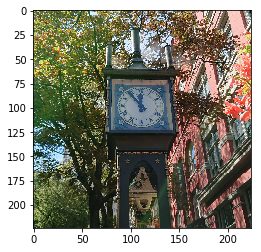

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

image_path = '../images/clock.jpg'
#image_path = '../images/koala.jpg'
#image_path = '../images/cake_zoom.jpg'

image = image_from_file(image_path, [224,224])
plt.imshow(image)

Perform the relevant pre-processing as done in the previous chapters. If you are interested in understanding this pre-processing step in greater detail, take a look in [chapter04/ResNet50Preprocessing.ipynb](../chapter04/resnet50_preprocessing.ipynb).

Put the image through the classifier and take a look at the top predictions.

In [3]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
import numpy as np

number_predictions = 10

image_for_resnet = preprocess_input(image)
image_for_resnet_list = np.expand_dims(image_for_resnet, 0)
decoded_predictions = decode_predictions(model.predict(image_for_resnet_list), top=number_predictions)
label = np.argmax(model.predict(image_for_resnet_list))

for pred in decoded_predictions[0]:
    print(pred[1], ':', pred[2])

analog_clock : 0.49137956
wall_clock : 0.46333772
barometer : 0.015819294
bell_cote : 0.0073449058
television : 0.0029275732
palace : 0.0027990725
altar : 0.0021295361
digital_clock : 0.0015451624
sundial : 0.0012383269
library : 0.0009314404


## Visualise Saliency using LIME

Import the relevant packages.

If you cloned this repo and created your environment with an earlier version of `strengthening-dnns.yml` before this notebook was updated on the master branch, you will need to extend your environment to include scikit-learn and LIME. Type the following at the Anaconda prompt and restart this notebook:

```
conda install lime
conda install scikit-learn
```

In [4]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
from skimage.segmentation import mark_boundaries
explainer = lime_image.LimeImageExplainer()


Set how many samples you would like to use for generating the explanation. More samples will give better results but will take longer depending on you machine and whether you are using a GPU. You may wish to initially test the notebook with a low number such as 50.

In [5]:
number_of_samples = 500

Create a lime 'explainer' for the ResNet50 model.

In [6]:
explanation = explainer.explain_instance(image_for_resnet_list[0], 
                                         model.predict, 
                                         top_labels=number_predictions, 
                                         hide_color=0, 
                                         num_samples=number_of_samples)


100% |########################################################################|


Couple of helper functions ...

In [7]:
MEAN_RGB_VALUES = np.array([123.68, 116.779, 103.939], dtype=np.float32) 
    
#The salient aspects of the image are highlighted in yellow in the cells below. 
#You might need this convert_to_grey function below if your image has a lot of yellow in it.    
def convert_to_grey(image):
    greyValue = 0.07 * image[:,:,2] + 0.72 * image[:,:,1] + 0.21 * image[:,:,0]
    grey_image = greyValue.astype(np.uint8)
    return grey_image

# Performs the pre-processing step backwards to get to the original image
def resnet_image_to_original(resnet_image, show_in_grey_scale=False):
    image_original_bgr = (image + MEAN_RGB_VALUES)
    image_original_rgb = (image_original_bgr[:,:,::-1])
    if show_in_grey_scale:
        image_original_rgb = convert_to_grey(image_original_rgb)
    image_original_rgb_0_to_1 = np.clip(image_original_rgb/255, 0, 1)
    return image_original_rgb_0_to_1
    

Now, get the image and the mask showing the top features for the classification

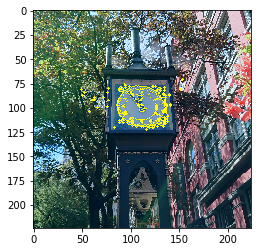

In [8]:
image, mask = explanation.get_image_and_mask(explanation.top_labels[0], # The label we are trying to explain
                                             positive_only=True, 
                                             num_features=5, 
                                             hide_rest=False)

plt.imshow(mark_boundaries(resnet_image_to_original(image, 
                                                    show_in_grey_scale=False), 
                           mask))

Now let's look at the features that were important in making the top 6 predictions for this image

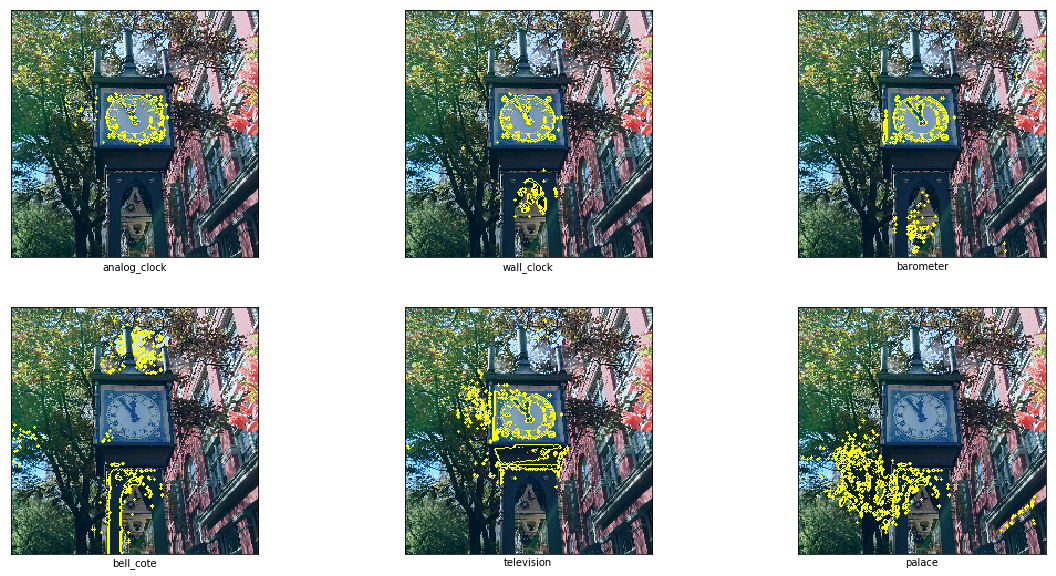

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    image, mask = explanation.get_image_and_mask(explanation.top_labels[i],
                                                 positive_only=True, 
                                                 num_features=5, 
                                                 hide_rest=False)
    
    plt.imshow(mark_boundaries(resnet_image_to_original(image, 
                                                    show_in_grey_scale=False), 
                               mask))
    
    predicted_label = decoded_predictions[0][i][1]

    plt.xlabel("{}".format(predicted_label)) 

Take a look at the [LIME documentation](https://lime-ml.readthedocs.io/en/latest/index.html)for details of the parameters in the calls above. You can experiment by depicting more features in the explanations (`num_features`) or the features which also impact the classification negatively (`positive_only`).

# Visualise Saliency using Keras-vis

This is the technique that was used to generate the examples in the book.

The gradients are extracted based on the output logits (returned prior to the softmax layer). The following code gets this output layer from the ResNet50 model.

To run this part of the notebook, you need to install a dependency that has not been released to PiPy as follows:

`pip install git+https://github.com/raghakot/keras-vis.git -U`

This avoids the bug described here: [keras-vis/issues/158](https://github.com/raghakot/keras-vis/issues/158). 

In [ ]:
from vis.utils import utils
from keras import activations

layer_idx = utils.find_layer_idx(model, 'fc1000')
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

C:\Users\katyw\Anaconda3\envs\strengthening-dnns\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Next, get the gradients using Keras-vis visualize_saliency.

Note that we pass the predicted label to this function. This ensures that the partial derivitive is calculated wrt that label - hence we see the gradients that are most important in calculating the target label.


In [ ]:
from vis.visualization import visualize_saliency
grads = visualize_saliency(model, 
                           layer_idx, 
                           filter_indices=label, 
                           seed_input=image_for_resnet, 
                           backprop_modifier='guided')

Instructions for updating:
Use tf.cast instead.


Plot the original image alongside the saliency map.

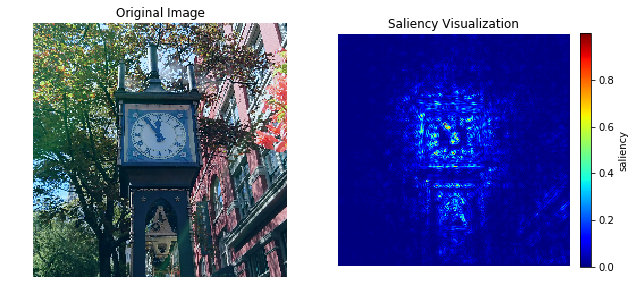

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))

plt.subplot(1,2, 1)
plt.axis('off')
plt.title('Original Image')
plt.imshow(resnet_image_to_original(image)) 

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Saliency Visualization')
plt.imshow(grads, cmap='jet') 
cb = plt.colorbar(fraction=0.046, pad=0.04) 
cb.set_label('saliency')
plt.show()

Alternatively, using a heatmap...

In [ ]:
from vis.visualization import visualize_cam

heatmap = visualize_cam(model, 
                        layer_idx, 
                        filter_indices=label, 
                        seed_input=image_for_resnet)

plt.imshow(image)    
plt.imshow(heatmap, cmap='jet', alpha = 0.6)
plt.show()